# Yahoo Finance (R)

In this project we,

- use Yahoo Finance API to download stock data
- investigate and clean the dataset
- visualise the shape of the data

Core packages

- https://cran.r-project.org/web/packages/yahoofinancer/index.html
- https://cran.r-project.org/web/packages/quantmod/index.html

In [1]:
# Libraries
library(tidyverse)
library(rvest)
library(httr2)
library(yahoofinancer)
library(quantmod)

Warning message:
"package 'ggplot2' was built under R version 4.5.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'rvest'


The following object is masked from 'package:readr':

    guess_encoding


Warning message:
"package 'yahoofinancer' was built under R version 4.5.2"
Warning message:
"package 'quantmod' was built under R version 4.5.2"
Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date,

In [2]:
# Set up Jupyter graph display
options(
  repr.plot.width  = 10,
  repr.plot.height = 6,
  repr.plot.res    = 150
)

## Investigate and clean the dataset

In [3]:
# nVidia stock
nvidia <-  Ticker$new("NVDA")
nvidia

<Ticker>
  Public:
    clone: function (deep = FALSE) 
    currency: active binding
    exchange_name: active binding
    exchange_timezone_name: active binding
    fifty_two_week_high: active binding
    fifty_two_week_low: active binding
    first_trade_date: active binding
    full_exchange_name: active binding
    get_history: function (period = "ytd", interval = "1d", start = NULL, end = NULL) 
    initialize: function (symbol = NA) 
    previous_close: active binding
    recommendations: active binding
    regular_market_day_high: active binding
    regular_market_day_low: active binding
    regular_market_price: active binding
    regular_market_time: active binding
    regular_market_volume: active binding
    set_symbol: function (symbol) 
    symbol: NVDA
    technical_insights: active binding
    timezone: active binding
    valuation_measures: active binding
  Private:
    base_url: https://query2.finance.yahoo.com
    cors_domain: finance.yahoo.com
    extract_valuation: f

In [4]:
# Extract dividends and splits from Yahoo Finance
dividends <- quantmod::getDividends("NVDA", from = "1970-01-01", auto.assign = FALSE)
splits <- quantmod::getSplits("NVDA",    from = "1970-01-01", auto.assign = FALSE)

# Construct data frames
div_df <- tibble(date = zoo::index(dividends), dividend = as.numeric(dividends)) |>
    mutate(date = ymd(date))

spl_df <- tibble(date = zoo::index(splits), split = as.numeric(splits)) |>
    mutate(date = ymd(date))


In [5]:
# Extract the history
nvidia_df <- nvidia$get_history(start = ymd("1970-01-01"), interval="1d")

nvidia_df <- nvidia_df |>
    janitor::clean_names() |>
    select(-adj_close) |>
    as_tibble() |>
    mutate(date = as.Date(date)) |>
    left_join(div_df, by = "date") |>
    left_join(spl_df, by = "date")

In [6]:
nvidia_df |> head()

date,volume,high,low,open,close,dividend,split
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1999-01-22,2714688000,0.048828,0.038802,0.043750,0.041016,NA,NA
1999-01-25,510480000,0.045833,0.041016,0.044271,0.045313,NA,NA
1999-01-26,343200000,0.046745,0.041146,0.045833,0.041797,NA,NA
1999-01-27,244368000,0.042969,0.039583,0.041927,0.041667,NA,NA
1999-01-28,227520000,0.041927,0.041276,0.041667,0.041536,NA,NA
1999-01-29,244032000,0.041667,0.039583,0.041536,0.039583,NA,NA


In [7]:
nvidia_df |> tail()

date,volume,high,low,open,close,dividend,split
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2026-01-21,200381000,185.38,178.40,179.05,183.32,NA,NA
2026-01-22,139636600,186.17,183.93,184.75,184.84,NA,NA
2026-01-23,142748100,189.60,186.82,187.50,187.67,NA,NA
2026-01-26,124799600,189.12,185.99,187.16,186.47,NA,NA
2026-01-27,143233500,190.00,185.70,187.24,188.52,NA,NA
2026-01-28,61937612,192.35,190.13,191.29,191.80,NA,NA


In [8]:
# Check NAs
nvidia_df |>
    summarise(
        across(
            .cols = everything(),
            .fns = ~ sum(is.na(.))
        )
    )

date,volume,high,low,open,close,dividend,split
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,6743,6791


In [9]:
# Check dividends and splits
nvidia_df |>
    select(dividend, split) |>
    summarise(
        across(
            .cols = everything(),
            .fns = ~ sum(!is.na(.))
        )
    )

dividend,split
<int>,<int>
53,5


In [10]:
nvidia_df |>
    filter(!is.na(dividend) | !is.na(split))

date,volume,high,low,open,close,dividend,split
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2000-06-27,604608000,0.348438,0.287760,0.342708,0.296875,NA,0.5000000
2006-04-07,682674000,0.512500,0.498833,0.508000,0.508833,NA,0.5000000
2007-09-11,405424000,0.871000,0.847750,0.856750,0.864500,NA,0.6666667
2012-11-20,336976000,0.290750,0.284250,0.289500,0.287250,0.001875,NA
2013-02-26,487504000,0.311000,0.305250,0.306250,0.309250,0.001875,NA
2013-05-21,357784000,0.374500,0.367000,0.371250,0.373000,0.001875,NA
2013-08-20,234192000,0.376250,0.371250,0.371750,0.373750,0.001875,NA
2013-11-19,206716000,0.394000,0.385500,0.390500,0.386000,0.002125,NA
2014-02-25,242184000,0.472000,0.463500,0.470000,0.468500,0.002125,NA


In [11]:
# Check the date
cat("The first and the last date of the series:\n", c(min(nvidia_df$date), max(nvidia_df$date)))

The first and the last date of the series:
 10613 20481

## The shape of the price at close

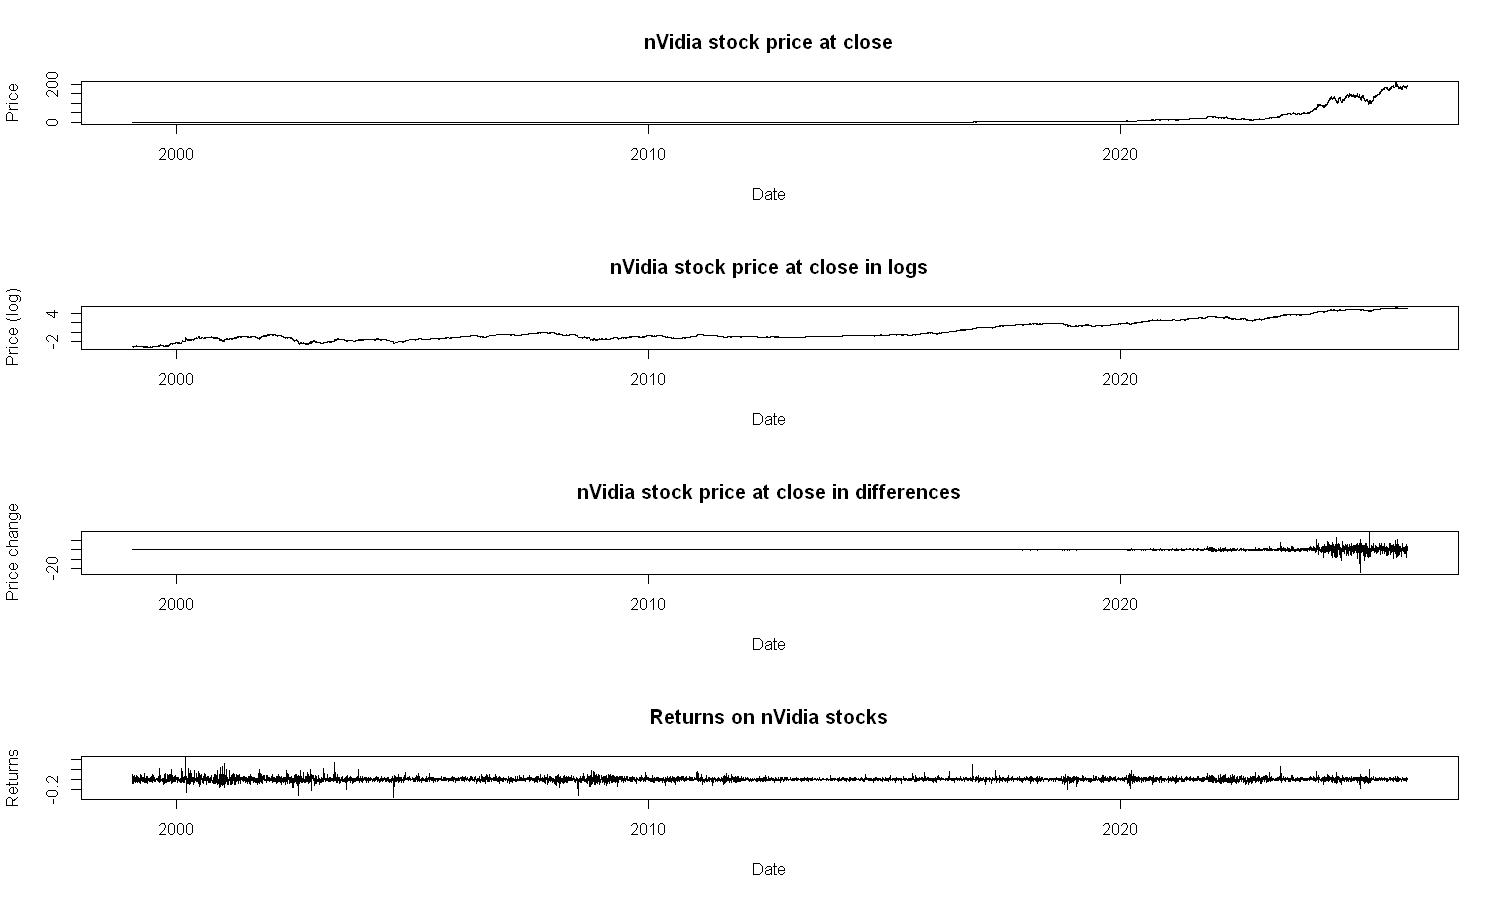

In [12]:
# Plot the price at close
par(mfrow = c(4, 1))

plot(
    x = nvidia_df$date, 
    y = nvidia_df$close, 
    type = "l",
    main = "nVidia stock price at close",
    xlab = "Date",
    ylab = "Price"
)

plot(
    x = nvidia_df$date, 
    y = log(nvidia_df$close), 
    type = "l",
    main = "nVidia stock price at close in logs",
    xlab = "Date",
    ylab = "Price (log)"
)

plot(
    x = nvidia_df$date, 
    y = nvidia_df$close - lag(nvidia_df$close), 
    type = "l",
    main = "nVidia stock price at close in differences",
    xlab = "Date",
    ylab = "Price change"
)

plot(
    x = nvidia_df$date, 
    y = (nvidia_df$close - lag(nvidia_df$close)) / lag(nvidia_df$close), 
    type = "l",
    main = "Returns on nVidia stocks",
    xlab = "Date",
    ylab = "Returns"
)

par(mfrow = c(1, 1))

## Unit root and integration

In [13]:
#